## Import Package

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Distance Approach

In [18]:
class DistanceApproach:

    def __init__(
        self,
        file_dir,
    ):
        self.all_data = self.read_all_data(file_dir)
        print("{} stocks found".format(str(len(self.all_data))))

        # selected pairs
        self.selected_pairs = []

        # euclidean square distance
        self.heatmap_df = None
        

    # read all csv file name under dir
    def read_all_data(self, file_dir):
        file_dir += "/"
        return glob.glob(file_dir + "*.csv")

    # read csv file and get close price
    def read_data(self, path1, path2, start_year, end_year):

        # intersect two stocks price on date
        x = pd.read_csv(path1)
        y = pd.read_csv(path2)
        x_y = pd.merge(left=x, right=y, how="inner", on="Date")

        # select part of dataframe in date range
        filter = x_y["Date"].str.contains(start_year)
        i = x_y[filter].index[0]
        filter = x_y["Date"].str.contains(end_year)
        j = x_y[filter].index[-1]
        x_y = x_y.iloc[i:j+1, :]

        # return close price
        x = np.array(x_y["Close_x"])
        y = np.array(x_y["Close_y"])

        return x, y

    # convert list of path to list of filename
    def paths2name(self, paths):
        result = []
        for path in paths:
            name = os.path.basename(path)
            result.append(name[:-4])
        return result

    # select pair based on Euclidean Square Distance (ESD)
    def select_pair(self, num_pair, start_year, end_year):

        pair_name = []
        pair_dist = []

        for i in range(len(self.all_data)):
            for j in range(len(self.all_data)):

                # read csv and get close price
                x, y = self.read_data(self.all_data[i], self.all_data[j], start_year, end_year)

                # normalize stock price
                x = (x - np.min(x)) / (np.max(x) - np.min(x))
                y = (y - np.min(y)) / (np.max(y) - np.min(y))

                # calculate distance
                dist = np.sum((x-y)**2)

                # store result
                pair_name.append([self.all_data[i], self.all_data[j]])
                pair_dist.append(dist)

        # draw heatmap
        matrix = np.array(pair_dist)
        matrix = np.reshape(matrix, (len(self.all_data), len(self.all_data)))
        self.heatmap_df = pd.DataFrame(data=matrix, index=self.paths2name(self.all_data), columns=self.paths2name(self.all_data))
        
        # sort pair_name by pair_dist in ascending order
        result = sorted(zip(pair_dist, pair_name))
        
        # display and save result
        self.selected_pairs.clear()
        idx = 0
        while idx < len(result):
            if result[idx][0] == 0:
                idx += 1
                continue

            self.selected_pairs.append(result[idx][1])
            idx += 2
        
        self.selected_pairs = self.selected_pairs[:num_pair]
            
    # draw heatmap
    def plot_heatmap(self):
        plt.figure(figsize=(10,10))
        plt.title("Euclidean Square Distance", fontsize=14)
        sn.heatmap(dist_app.heatmap_df, vmin=0, vmax=100)
        plt.savefig("/gdrive/MyDrive/專題/code/result/exp1/euclidean_square_dist.png")

In [19]:
dist_app = DistanceApproach(
    file_dir="/gdrive/MyDrive/專題/data/dataset1",
)

27 stocks found


=======Selected Pairs=======

======Distance Heatmap======


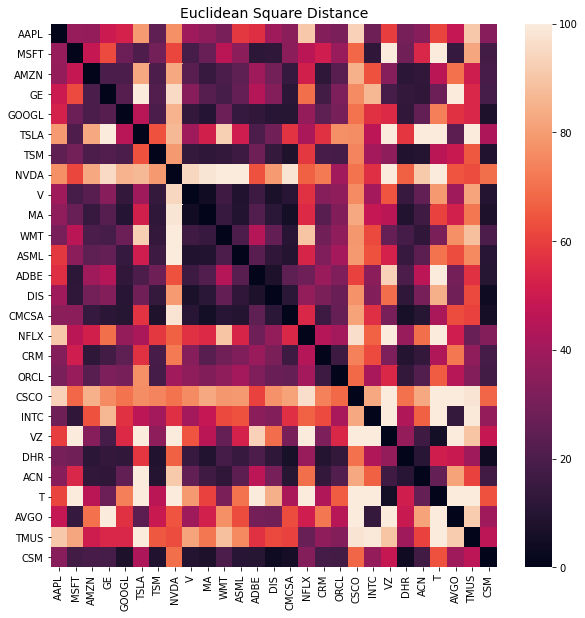

In [20]:
dist_app.select_pair(num_pair=6, start_year="2010", end_year="2014")
print("=======Selected Pairs=======")
dist_app.selected_pairs
print()

print("======Distance Heatmap======")
dist_app.plot_heatmap()

# Cointegration Approach

In [34]:
class CointegrationApproach:

    def __init__(
        self,
        file_dir,
    ):
        self.all_data = self.read_all_data(file_dir)
        print("{} stocks found".format(str(len(self.all_data))))

        # selected pairs
        self.selected_pairs = []
        

    # read all csv file name under dir
    def read_all_data(self, file_dir):
        file_dir += "/"
        return glob.glob(file_dir + "*.csv")

    # read csv file and get close price
    def read_data(self, path1, path2, start_year, end_year):

        # intersect two stocks price on date
        x = pd.read_csv(path1)
        y = pd.read_csv(path2)
        x_y = pd.merge(left=x, right=y, how="inner", on="Date")

        # select part of dataframe in date range
        filter = x_y["Date"].str.contains(start_year)
        i = x_y[filter].index[0]
        filter = x_y["Date"].str.contains(end_year)
        j = x_y[filter].index[-1]
        x_y = x_y.iloc[i:j+1, :]

        # return close price
        x = np.array(x_y["Close_x"])
        y = np.array(x_y["Close_y"])

        return x, y

    # select pair based on Johansen Test
    def select_pair(self, num_pair, start_year, end_year):

        pair_name = []
        pair_diff = []

        for i in range(0, len(self.all_data)-1):
            for j in range(i+1, len(self.all_data)):

                # read csv and get close price
                x, y = self.read_data(self.all_data[i], self.all_data[j], start_year, end_year)
                df = pd.DataFrame({"x": x, "y": y})
                result = coint_johansen(df, 0, 1)

                trace = result.lr1[0]
                trace_thed = result.cvt[0][1]

                eigen = result.lr2[0]
                eigen_thed = result.cvm[0][1]

                if trace > trace_thed and eigen > eigen_thed:
                    pair_name.append([self.all_data[i], self.all_data[j]])
                    pair_diff.append((trace-trace_thed) + (eigen-eigen_thed))
        
        self.selected_pairs = [item[1] for item in sorted(zip(pair_diff, pair_name), reverse=True)]
        self.selected_pairs = self.selected_pairs[:num_pair]
    
    # convert list of path to list of filename
    def paths2name(self, paths):
        result = []
        for path in paths:
            name = os.path.basename(path)
            result.append(name[:-4])
        return result

    # plot heatmap
    def plot_heatmap(self, start_year, end_year):

        pair_name = []
        pair_dist = []

        for i in range(len(self.all_data)):
            for j in range(len(self.all_data)):

                if i == j:
                    pair_name.append([self.all_data[i], self.all_data[j]])
                    pair_dist.append(np.nan)
                    continue

                # read csv and get close price
                x, y = self.read_data(self.all_data[i], self.all_data[j], start_year, end_year)

                df = pd.DataFrame({"x": x, "y": y})
                result = coint_johansen(df, 0, 1)

                trace = result.lr1[0]
                trace_thed = result.cvt[0][1]

                eigen = result.lr2[0]
                eigen_thed = result.cvm[0][1]

                dist = ((trace - trace_thed) + (eigen - eigen_thed)) / 2

                # store result
                pair_name.append([self.all_data[i], self.all_data[j]])
                pair_dist.append(dist)

        # draw heatmap
        matrix = np.array(pair_dist)
        matrix = np.reshape(matrix, (len(self.all_data), len(self.all_data)))
        self.heatmap_df = pd.DataFrame(data=matrix, index=self.paths2name(self.all_data), columns=self.paths2name(self.all_data))

        '''
        plt.figure(figsize=(10,10))
        plt.title("Cointegration Relationship", fontsize=14)
        sn.heatmap(heatmap_df, vmin=0, vmax=100)
        plt.savefig("/gdrive/MyDrive/專題/code/result/exp1/cointegration_relationship.png")
        '''

In [35]:
coint_app = CointegrationApproach(
    file_dir="/gdrive/MyDrive/專題/data/dataset1",
)

27 stocks found


In [8]:
coint_app.select_pair(num_pair=6, start_year="2010", end_year="2014")
print("=======Selected Pairs=======")
coint_app.selected_pairs

=======Selected Pairs=======


[['/gdrive/MyDrive/專題/data/dataset1/TSM.csv',
  '/gdrive/MyDrive/專題/data/dataset1/ACN.csv'],
 ['/gdrive/MyDrive/專題/data/dataset1/NFLX.csv',
  '/gdrive/MyDrive/專題/data/dataset1/TMUS.csv'],
 ['/gdrive/MyDrive/專題/data/dataset1/CRM.csv',
  '/gdrive/MyDrive/專題/data/dataset1/DHR.csv'],
 ['/gdrive/MyDrive/專題/data/dataset1/CMCSA.csv',
  '/gdrive/MyDrive/專題/data/dataset1/CRM.csv'],
 ['/gdrive/MyDrive/專題/data/dataset1/GE.csv',
  '/gdrive/MyDrive/專題/data/dataset1/CMCSA.csv'],
 ['/gdrive/MyDrive/專題/data/dataset1/DIS.csv',
  '/gdrive/MyDrive/專題/data/dataset1/CSM.csv'],
 ['/gdrive/MyDrive/專題/data/dataset1/GOOGL.csv',
  '/gdrive/MyDrive/專題/data/dataset1/CRM.csv']]

In [36]:
coint_app.plot_heatmap(start_year="2010", end_year="2014")

In [40]:
coint_app.heatmap_df.describe()

,AAPL,MSFT,AMZN,GE,GOOGL,TSLA,TSM,NVDA,V,MA,WMT,ASML,ADBE,DIS,CMCSA,NFLX,CRM,ORCL,CSCO,INTC,VZ,DHR,ACN,T,AVGO,TMUS,CSM
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,-10.387758,-6.890794,-7.397733,-5.860217,-6.608449,-6.878505,-6.240172,-6.300794,-6.998143,-7.593789,-8.096870,-7.266174,-6.073750,-7.078467,-6.044578,-9.210356,-3.528514,-6.997637,-8.506216,-9.707916,-7.559837,-6.672252,-6.641187,-8.943176,-7.579877,-8.877525,-7.529393
std,1.727042,2.039556,2.681471,3.135303,3.250677,2.781970,3.798519,1.791671,2.542643,2.860803,2.321840,2.603727,2.737769,3.240615,4.086168,3.433254,3.606911,2.382710,1.176091,2.335489,2.852670,3.424122,3.795980,2.323638,2.337066,3.271252,3.286508
min,-12.425170,-10.118285,-11.489278,-11.702124,-12.425170,-11.271422,-11.668718,-9.305673,-11.421551,-12.102476,-12.129410,-11.997635,-10.679337,-11.438955,-12.271068,-12.102476,-9.406617,-11.098035,-10.610731,-12.271068,-12.190021,-11.854275,-11.904919,-12.041515,-10.050346,-11.214002,-12.092157
25%,-11.648913,-8.299220,-9.336101,-7.913995,-8.712104,-8.960677,-8.915305,-7.716395,-8.806688,-9.689680,-9.656141,-8.933268,-8.115954,-9.512837,-9.284139,-11.179309,-6.380767,-8.754818,-9.182214,-11.330895,-9.803809,-9.110316,-8.906216,-10.444863,-9.684032,-10.554758,-10.097309
50%,-10.707381,-7.165307,-7.651518,-6.639184,-7.426067,-7.265445,-6.694710,-6.651263,-7.285588,-7.382159,-8.497598,-7.342143,-6.641449,-7.774222,-6.505577,-9.917247,-2.857922,-7.347796,-8.656146,-10.427676,-7.630112,-6.405120,-7.040805,-9.345369,-8.013000,-9.643952,-8.209177
75%,-9.819484,-6.279782,-6.201549,-4.036326,-4.683343,-5.870355,-4.639351,-4.821053,-5.111620,-5.664820,-6.535612,-5.370370,-4.173691,-5.656885,-2.745416,-8.692145,-1.558738,-5.031347,-7.902289,-9.023743,-6.049463,-4.816320,-5.433750,-7.949763,-6.684371,-8.770279,-5.773145
max,-6.243407,-2.484378,-0.890136,1.997073,0.879659,0.683618,5.601597,-2.734917,-2.357972,-0.588413,-3.792458,-1.602455,-1.166930,1.506534,2.651917,4.893529,3.586835,-2.720039,-4.845007,-3.566548,-0.495170,3.586835,5.601597,-2.199454,-2.734917,4.893529,1.506534


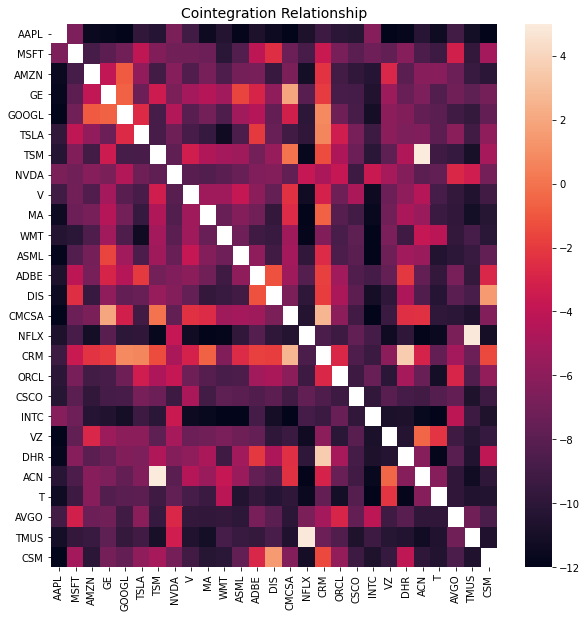

In [46]:
plt.figure(figsize=(10,10))
plt.title("Cointegration Relationship", fontsize=14)
sn.heatmap(coint_app.heatmap_df, vmin=-12, vmax=5)
plt.savefig("/gdrive/MyDrive/專題/code/result/exp1/cointegration_relationship.png")

## Debug

In [9]:
path1 = '/gdrive/MyDrive/專題/data/dataset1/DIS.csv'
path2 = '/gdrive/MyDrive/專題/data/dataset1/CSM.csv'

In [10]:
# intersect two stocks price on date
x = pd.read_csv(path1)
y = pd.read_csv(path2)
x_y = pd.merge(left=x, right=y, how="inner", on="Date")

# select part of dataframe in date range
filter = x_y["Date"].str.contains("2010")
i = x_y[filter].index[0]
filter = x_y["Date"].str.contains("2014")
j = x_y[filter].index[-1]
x_y = x_y.iloc[i:j+1, :]

# return close price
x = np.array(x_y["Close_x"])
y = np.array(x_y["Close_y"])

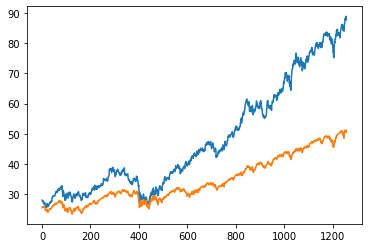

In [11]:
plt.plot(x)
plt.plot(y)

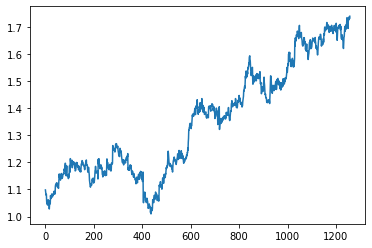

In [12]:
plt.plot(x/y)